In [1]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

/home/nurzhan/Projects/chronos-kickstart/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
context_df = pd.read_csv("../data/train.csv")
print("Input dataframe shape:", context_df.shape)
display(context_df.head())

Input dataframe shape: (353500, 3)


,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


In [3]:
pred_df = pipeline.predict_df(context_df, prediction_length=24, quantile_levels=[0.1, 0.5, 0.9])

print("Output dataframe shape:", pred_df.shape)
display(pred_df.head())

Output dataframe shape: (9936, 7)


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,H1,1750-01-30 04:00:00,target,624.867981,611.385071,624.867981,638.598755
1,H1,1750-01-30 05:00:00,target,563.703125,546.655090,563.703125,578.665649
2,H1,1750-01-30 06:00:00,target,521.589905,505.747498,521.589905,537.950806
3,H1,1750-01-30 07:00:00,target,489.910706,473.671814,489.910706,508.854126
4,H1,1750-01-30 08:00:00,target,471.144470,452.199402,471.144470,491.050354


In [4]:
# Energy price forecasting configuration
target = "target"  # Column name containing the values to forecast (energy prices)
prediction_length = 24  # Number of hours to forecast ahead
id_column = "id"  # Column identifying different time series (countries/regions)
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "DE"  # Specific time series to visualize (Germany)

# Load historical energy prices and past values of covariates
energy_context_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet", engine='fastparquet'
)
display(energy_context_df.head())

# Load future values of covariates
energy_test_df = pd.read_parquet(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet", engine='fastparquet'
)
energy_future_df = energy_test_df.drop(columns=target)
display(energy_future_df.head())

,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902


,id,timestamp,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2017-12-12 00:00:00,20483.00,22284.005859
1,DE,2017-12-12 01:00:00,19849.75,22878.673828
2,DE,2017-12-12 02:00:00,19638.25,23632.283203
3,DE,2017-12-12 03:00:00,19895.25,24635.945312
4,DE,2017-12-12 04:00:00,20338.00,25584.935547


In [5]:
# Generate predictions with covariates
energy_pred_df = pipeline.predict_df(
    energy_context_df,
    future_df=energy_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
display(energy_pred_df.head())

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,22.242920,18.673725,22.242920,25.403456
1,DE,2017-12-12 01:00:00,target,19.525616,14.904280,19.525616,23.316597
2,DE,2017-12-12 02:00:00,target,17.415367,12.209047,17.415367,21.776978
3,DE,2017-12-12 03:00:00,target,16.979263,11.165123,16.979263,21.435221
4,DE,2017-12-12 04:00:00,target,18.058655,12.096773,18.058655,23.166645


In [6]:
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

/tmp/ipykernel_43892/3752812453.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


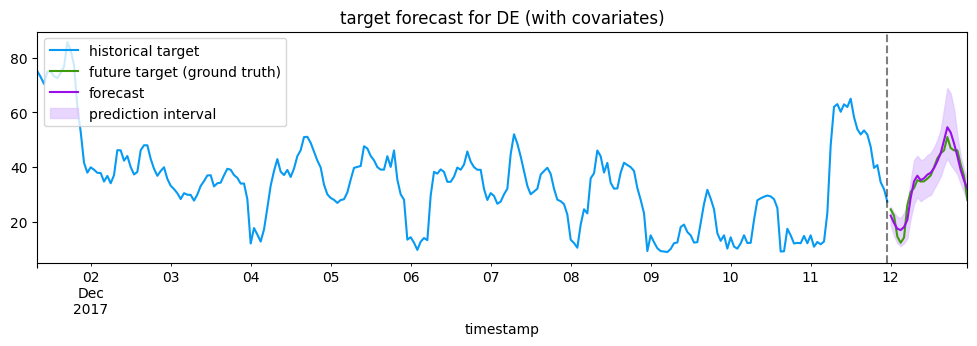

In [7]:
plot_forecast(
    energy_context_df,
    energy_pred_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)